In [1]:
import pandas as pd
import os 
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from src.sampler import Sampler 
from src.dataset import Dataset
from torch.utils.data import DataLoader
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from src.classifier import Classifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

%load_ext autoreload 
%autoreload 2

In [25]:
def check_cds(df:pd.DataFrame):
    feature_col = 'feature' if ('feature' in df.columns) else 'ref_feature' 
    features = ', '.join([str(feature) for feature in df[feature_col].unique()])
    # assert np.all(df[feature_col] == 'CDS'), f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}'
    if not np.all(df[feature_col] == 'CDS'):
        warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')

def get_hypothetical(df:pd.DataFrame):
    product_col = 'product' if ('product' in df.columns) else 'ref_product'
    return df.copy()[df[product_col] == 'hypothetical protein']

def get_ab_initio(df:pd.DataFrame):
    evidence_type_col = 'evidence_type' if ('evidence_type' in df.columns) else 'ref_evidence_type'
    return df.copy()[df[evidence_type_col] == 'ab initio prediction']

def get_suspect(df:pd.DataFrame):
    return get_hypothetical(get_ab_initio(df))

def get_frac_hypothetical(df:pd.DataFrame):
    check_cds(df)
    return len(get_hypothetical(df)) / len(df)

def get_frac_ab_initio(df:pd.DataFrame):
    check_cds(df)
    return len(get_ab_initio(df)) / len(df)

def get_frac_suspect(df:pd.DataFrame):
    check_cds(df)
    return len(get_suspect(df)) / len(df)


def get_lengths(df:pd.DataFrame, ref:bool=True, max_length:int=500):
    start_col, stop_col = ('ref_' if ref else '') +'start', ('ref_' if ref else '') + 'stop'
    lengths = df[stop_col] - df[start_col] 
    lengths = lengths // 3 + 1 # Convert to amino acid units. 
    if max_length is not None:
        lengths = lengths[lengths < max_length]
    return lengths

In [37]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

genome_metadata_df = load_genome_metadata()

load_ref_out:   0%|          | 0/137 [00:00<?, ?it/s]

load_ref_out: 100%|██████████| 137/137 [00:03<00:00, 35.50it/s]


remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


In [36]:
print('Maximum false positive length:', ref_out_fp_df.seq.apply(len).max())
print('Minimum false positive length:', ref_out_fp_df.seq.apply(len).min())

Maximum false positive length: 6469
Minimum false positive length: 29


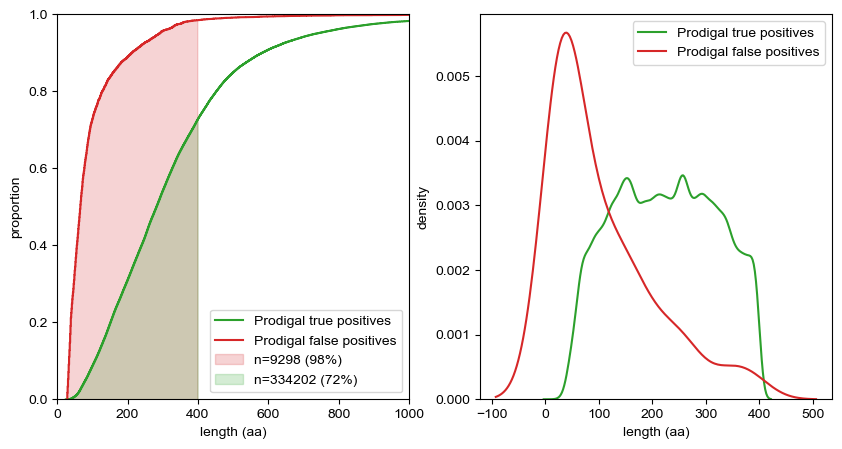

In [41]:
def figure_1(ref_out_df, path:str='../figures/filter-figure_1.png'):

    ref_out_0_df = ref_out_df[ref_out_df.ref_feature == 'CDS'].copy()
    ref_out_1_df = ref_out_df[ref_out_df.ref_feature != 'CDS'].copy()

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    ax = axes[0]
    ax = sns.ecdfplot(ref_out_0_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    ax = sns.ecdfplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')

    x_0, y_0 = ax.get_lines()[0].get_data()
    x_1, y_1 = ax.get_lines()[1].get_data()

    x_0, x_1, y_0, y_1 = x_0[1:], x_1[1:], y_0[1:], y_1[1:]

    max_length = 400

    n_0 = (x_0 < max_length).sum()
    n_1 = (x_1 < max_length).sum()
    p_0 = int(n_0 * 100 / len(x_0))
    p_1 = int(n_1 * 100 / len(x_1))

    ax.fill_between(x_1[x_1 < max_length], y_1[x_1 < max_length], color='tab:red', alpha=0.2, label=f'n={n_1} ({p_1}%)')
    ax.fill_between(x_0[x_0 < max_length], y_0[x_0 < max_length], color='tab:green', alpha=0.2, label=f'n={n_0} ({p_0}%)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('proportion')
    ax.set_xlabel('length (aa)')
    ax.legend()

    ax = axes[1]
    sns.kdeplot(get_lengths(ref_out_0_df, max_length=max_length), ax=ax, color='tab:green', label=f'Prodigal true positives')
    sns.kdeplot(get_lengths(ref_out_1_df, max_length=max_length), ax=ax, color='tab:red', label=f'Prodigal false positives')
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlabel('length (aa)')

    plt.show()

figure_1(ref_out_df)

In [45]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
ref_out_0_df = ref_out_df[ref_out_df.ref_feature == 'CDS'].copy()
ref_out_1_df = ref_out_df[ref_out_df.ref_feature != 'CDS'].copy()

dataset_df = pd.concat([ref_out_1_df.assign(label=1), ref_out_0_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400]

train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)

In [46]:
def fix_dtypes(df:pd.DataFrame):
    df = df.copy().convert_dtypes()
    for col in df.columns:
        if df[col].dtype == 'string[python]':
            df[col] = df[col].fillna('none')
        if df[col].dtype == 'boolean':
            df[col] = df[col].fillna(False)
        if df[col].dtype in ['Int64', 'Float64']:
            df[col].fillna(-1)
    return df 

fix_dtypes(train_dataset_df).to_csv('../data/filter_dataset_train.csv')
fix_dtypes(test_dataset_df).to_csv('../data/filter_dataset_test.csv')

In [47]:
print((train_dataset_df.label == 0).sum() / len(train_dataset_df))
print((train_dataset_df.label == 1).sum() / len(train_dataset_df))
print((test_dataset_df.label == 0).sum() / len(test_dataset_df))
print((test_dataset_df.label == 1).sum() / len(test_dataset_df))

0.972538064788343
0.027461935211656956
0.9722691031833789
0.027730896816621078


In [10]:
pred_out_df = pd.read_csv('../data/predict.out/filter_dataset_test.predict.csv', index_col=0)
# Add the metadata to the predictions. 
pred_out_df = pred_out_df.merge(ref_out_df, left_index=True, right_index=True, how='left')
pred_out_df = pred_out_df.merge(genome_metadata_df[['species']], left_on='genome_id', right_index=True, how='left')


/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


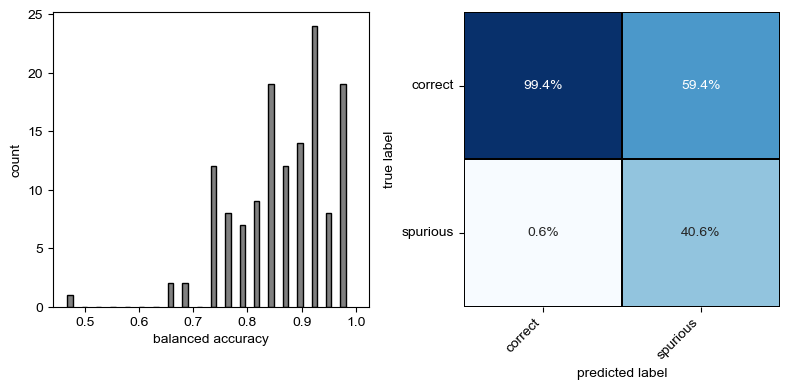

/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
126074 bytes written to file /tmp/tmp2il8ibw6/temp.png


,acc.,num. pred. false pos.,num. false pos.,num. pred. true pos.,num. true pos.
species,,,,,
Acholeplasma_D palmae,0.467822,13,1,190,202
Caulobacter zeae,0.658252,13,3,703,713
Spirochaeta_A thermophila,0.660215,6,6,310,310
Desulfovirgula thermocuniculi,0.699580,17,7,466,476
Thermaerobacter subterraneus,0.704365,16,9,329,336
...,...,...,...,...,...
Hippea sp000526195,0.989960,8,3,244,249
Izemoplasma_B sp000755705,0.990494,6,1,258,263
Guyparkeria sp001641825,0.992883,7,3,277,281


In [11]:
# First thing I want to look at is the accuracy per genome. 
fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

ax = axes[0]
accs = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.filter_balance_classes_and_lengths_label), include_groups=False)
ax.hist(accs, bins=20, color='gray', width=0.01, edgecolor='black')
ax.set_xlabel('balanced accuracy')
ax.set_ylabel('count')

ax = axes[1]
labels = ['correct', 'spurious']
matrix = confusion_matrix(pred_out_df.label.values, pred_out_df.filter_balance_classes_and_lengths_label.values) #, labels=sorted(pred_out_df.label.unique()))
matrix = pd.DataFrame(matrix, columns=labels, index=labels)
matrix = matrix.apply(lambda x: x/x.sum(), axis=0) # Normalize the matrix.

sns.heatmap(matrix, ax=ax, annot=True, cbar=False, linecolor='black', lw=0.2, fmt='.1%', cmap='Blues') # fmt='.1%',

# Rotate the tick labels on the x-axis of each subplot.
ax.set_xticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=0)
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')

plt.show()

# The UserWarning from scikitlearn is because some of the genomes have no Prodigal false positives in the testing set. 

def table_1(pred_out_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['acc.'] = pred_out_df.groupby('species').apply(lambda df : balanced_accuracy_score(df.label, df.filter_balance_classes_and_lengths_label) , include_groups=False)
    
    table_df['num. pred. false pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.filter_balance_classes_and_lengths_label == 1).sum(), include_groups=False)
    table_df['num. false pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.label == 1).sum(), include_groups=False)
    table_df['num. pred. true pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.filter_balance_classes_and_lengths_label == 0).sum(), include_groups=False)
    table_df['num. true pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.label == 0).sum(), include_groups=False)
    table_df = pd.DataFrame(table_df)
    
    table_df = table_df.sort_values('acc.')
    dfi.export(table_df.iloc[:50], path)
    return table_df
    
# warnings.simplefilter('ignore')
table_1(pred_out_df)

/tmp/ipykernel_1834745/2142004552.py:6: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, nan, rRNA, tRNA, ncRNA, misc_feature, misc_RNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/tmp/ipykernel_1834745/2142004552.py:6: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_RNA, misc_feature, ncRNA, rRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/tmp/ipykernel_1834745/2142004552.py:6: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_feature, misc_RNA, rRNA, tRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')


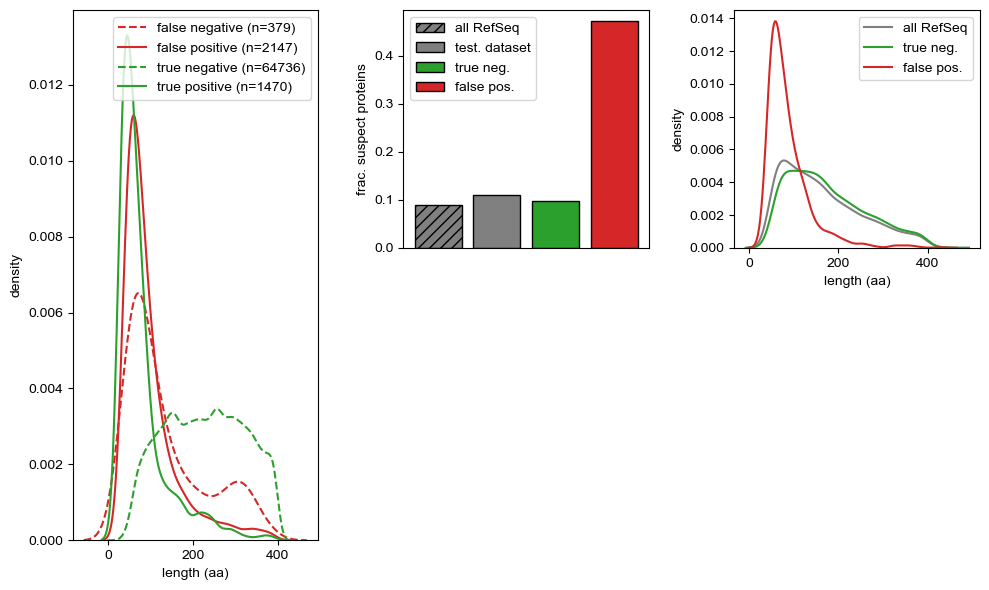

In [29]:
# I am mainly worried about the things that the model has predicted to be wrong, but are actually correct. 
# It does seem to have mainly just learned length. 
def figure_3(pred_out_df:pd.DataFrame, ref_out_df:pd.DataFrame, path:str=None, model_name:str='filter_balance_classes_and_lengths'):

    error_types = np.where((pred_out_df[f'{model_name}_label'] == 1) & (pred_out_df.label == 0), 'false positive', '')
    error_types = np.where((pred_out_df[f'{model_name}_label']  == 1) & (pred_out_df.label == 1), 'true positive', error_types)
    error_types = np.where((pred_out_df[f'{model_name}_label']  == 0) & (pred_out_df.label == 1), 'false negative', error_types)
    error_types = np.where((pred_out_df[f'{model_name}_label']  == 0) & (pred_out_df.label == 0), 'true negative', error_types)
    pred_out_df['error_type'] = error_types

    kwargs = dict()
    kwargs['false positive'] = {'color':'tab:red'}
    kwargs['true positive'] = {'color':'tab:green'}
    kwargs['false negative'] = {'color':'tab:red', 'ls':'--'}
    kwargs['true negative'] = {'color':'tab:green', 'ls':'--'}

    fig = plt.figure(layout='tight', figsize=(10, 6))
    grid = GridSpec(nrows=2, ncols=3, figure=fig)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = fig.add_subplot(grid[0, 1])
    ax_c = fig.add_subplot(grid[0, 2])

    for error_type, df in pred_out_df.groupby('error_type'):
        sns.kdeplot(df.seq.apply(len), label=f'{error_type} (n={len(df)})', **kwargs[error_type], ax=ax_a)
    ax_a.legend()
    ax_a.set_ylabel('density')
    ax_a.set_xlabel('length (aa)')
    
    labels = ['all RefSeq', 'test. dataset', 'true neg.', 'false pos.']
    positions = np.arange(len(labels))
    heights = list()
    heights += [get_frac_suspect(ref_out_df)]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.ref_feature == 'CDS'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.error_type == 'true negative'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.error_type == 'false positive'])]
    ax_b.bar(positions, heights, label=labels, color=['gray', 'gray', 'tab:green', 'tab:red'], edgecolor='black', hatch=['///', None, None, None])
    ax_b.set_ylabel('frac. suspect proteins')
    ax_b.set_xticks([])
    ax_b.legend()


    sns.kdeplot(get_lengths(get_suspect(pred_out_df)), color='gray', ax=ax_c, label='all RefSeq')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.error_type == 'true negative'])), color='tab:green', ax=ax_c, label='true neg.')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.error_type == 'false positive'])), color='tab:red', ax=ax_c, label='false pos.')
    ax_c.legend()
    ax_c.set_ylabel('density')
    ax_c.set_xlabel('length (aa)')
    plt.show()


figure_3(pred_out_df, ref_out_df)
    # Does this have something to do with the truncation sizes of the false positives versus true positives, or is it really just length?

    # for error_type in ['false positive', 'true negative']:
    #     df = pred_out_df[pred_out_df.error_type == error_type]
    #     diffs = [((row.ref_stop - row.ref_start) - (row.stop - row.stop)) // 3 for row in df.itertuples()]
    #     ref_lengths = [(row.ref_stop - row.ref_start) // 3 for row in df.itertuples()] 
    #     lengths = [(row.stop - row.start) // 3 for row in df.itertuples()] 
    #     ax.scatter(lengths, df.filter_balance_classes_and_lengths_output_1,  s=5, **kwargs[error_type])
    # ax.set_xscale('log')

In [34]:
pred_out_fp_df.ref_feature.value_counts()

ref_feature
CDS             2122
rRNA              16
tRNA               6
misc_feature       2
misc_RNA           1
Name: count, dtype: int64

In [33]:
pred_out_df[pred_out_df.error_type == 'false positive'].ref_product.value_counts()
pred_out_df[pred_out_df.error_type == 'true negative'].ref_product.value_counts()

pred_out_fp_df = pred_out_df[pred_out_df.error_type == 'false positive']
pred_out_tn_df = pred_out_df[pred_out_df.error_type == 'true negative']

pred_out_df[(pred_out_df.ref_product == 'hypothetical protein') & pred_out_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_out_fp_df[(pred_out_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_out_tn_df[(pred_out_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [ ]:
get_ab_initio(pred_out_df).ref_product.value_counts() / len(get_ab_initio(pred_out_df))

ref_product
hypothetical protein                                            0.889170
helix-turn-helix domain-containing protein                      0.001927
putative integral inner membrane protein                        0.001325
conserved protein of unknown function; phage SPbeta             0.001084
alpha/beta hydrolase                                            0.001084
                                                                  ...   
PseG/SpsG family protein                                        0.000120
putative efflux transporter; prophage 1 region                  0.000120
ubiquitin carboxyl-terminal hydrolase family protein            0.000120
putative glycosyltransferase (complex carbohydrate synthase)    0.000120
efflux RND transporter periplasmic adaptor subunit              0.000120
Name: count, Length: 645, dtype: float64

In [81]:
# What fraction of the entire reference is a hypothetical protein?
(ref_out_df.ref_product == 'hypothetical protein').sum() / len(ref_out_df)
(pred_out_df.ref_product == 'hypothetical protein').sum() / len(pred_out_df)
(pred_out_df[pred_out_df.error_type == 'false positive'].ref_product == 'hypothetical protein').sum() / len(pred_out_df[pred_out_df.error_type == 'false positive'])
(pred_out_df[pred_out_df.error_type == 'true negative'].ref_product == 'hypothetical protein').sum() / len(pred_out_df[pred_out_df.error_type == 'true negative'])


np.float64(0.16046712802768165)

In [ ]:
# What is the length distribution of hypothetical proteins versus Prodigal errors?

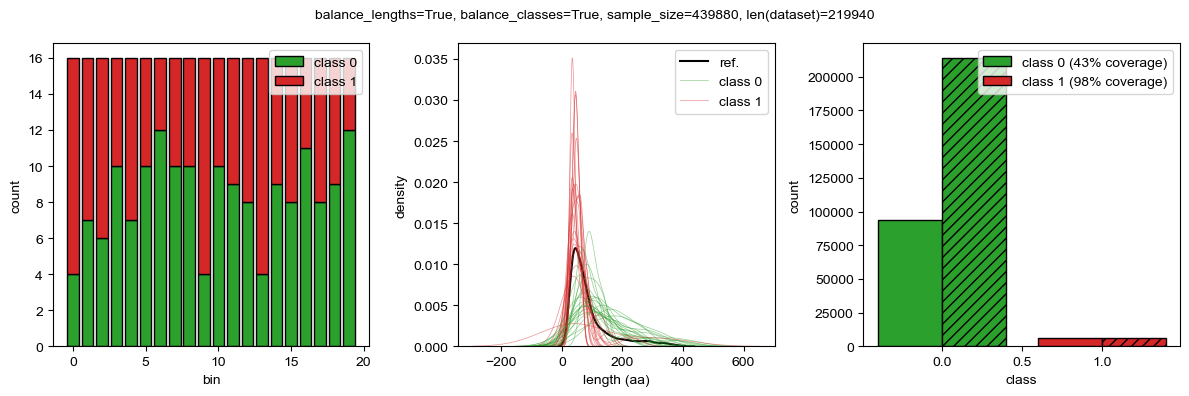

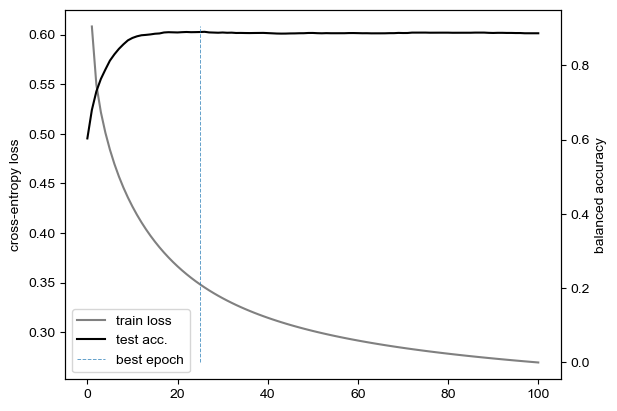

In [72]:
model = Classifier.load('../models/filter_balance_classes_and_lengths.pkl')
model.sampler.plot()
model.plot()

In [ ]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7958396559282479
Balanced train accuracy: 0.7948956639028347


In [56]:
model.n_iter_

array([18], dtype=int32)